In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# Add src directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))

from pricing.triple_win import TripleWinPricing, TrackingTripleWinPricing
from pricing.buyer import BuyerBlock
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


In [3]:
df_shapley = pd.read_csv("../tables/unified_shapley_matrix_10sellers.csv")

selected_columns = []

MODELS_NUM = 10

for i in range(10):
    selected_columns.append(f"seller_{i}")
SV = df_shapley[selected_columns].sample(MODELS_NUM).values.transpose()
SV = SV / SV.sum(axis=0, keepdims=True)

Saved to: ..\plots\fixed_point.pdf


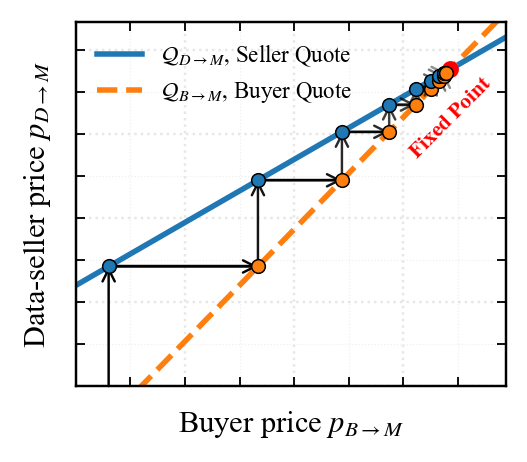

In [10]:
# Fixed-point iteration cobweb diagram (IEEE single-column style, fading convergence)
# - Times New Roman font
# - Buyer curve = orange (tab10[1]), Seller curve = blue (tab10[0])
# - Fading cobweb lines as convergence proceeds
# - Figure size tuned for IEEE single-column (3.5 x 2.8 in)

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------- Matplotlib style ----------------
mpl.rcParams.update({
    "figure.dpi": 220,
    "savefig.dpi": 600,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "mathtext.fontset": "stix",
    "axes.titlesize": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 7.5,
    "axes.linewidth": 0.8,
})

# Figure size (IEEE single-column)
fig_w_in = 2.5
fig_h_in = 2.2

# ---------------- Parameters ----------------
a = 0.6
b = 0.75
c = 0.3
d = 0.75
assert abs(d*b) < 1.0, "Choose b and d so that |d*b|<1 for convergence."

# Fixed point
x_star = (d*a + c) / (1.0 - d*b)
y_star = a + b*x_star

# Iteration path
x0 = 0.15
T = 8
xs = [x0]
ys = [0.0]
x = x0

for _ in range(T):
    y = a + b*x
    xs.append(x)
    ys.append(y)
    x = c + d*y
    xs.append(x)
    ys.append(y)

# Domain for curves
xmin = 0.0
xmax = max(1.15*max(xs + [x_star]), 1.0)
xx = np.linspace(xmin, xmax, 600)
y_fx = a + b*xx
y_ginv = (xx - c) / d
ymin = 0.0
ymax = max(1.15*max(ys + [y_star]), 1.5)

# ---------------- Plot ----------------
fig = plt.figure(figsize=(fig_w_in, fig_h_in))
ax = plt.gca()

seller_color = plt.cm.tab10(0)  # blue
buyer_color  = plt.cm.tab10(1)  # orange

# Seller-side: y = f(x)
ax.plot(xx, y_fx, linewidth=1.8, color=seller_color, label=r"$\mathcal{Q}_{D\to M}$, Seller Quote")

# Buyer-side: y = g^{-1}(x)
ax.plot(xx, y_ginv, linewidth=1.8, linestyle="--", color=buyer_color, label=r"$\mathcal{Q}_{B\to M}$, Buyer Quote")

# ---------------- Fading cobweb path with dots on both curves ----------------
arrow_kw = dict(arrowstyle="->", linewidth=1.1, shrinkA=0, shrinkB=0, mutation_scale=6)
num_steps = int(len(xs) / 2)

for i in range(0, len(xs)-1, 2):
    step = i // 2
    alpha_val = 1.0 - (step / num_steps) * 0.65
    color = (0, 0, 0, alpha_val)

    # Vertical move: from (x_t, y_{t-1}) to (x_t, f(x_t))
    ax.plot([xs[i], xs[i]], [ys[i], ys[i+1]], color=color, linewidth=0.0)
    ax.annotate("", xy=(xs[i], ys[i+1]), xytext=(xs[i], ys[i]),
                arrowprops=dict(arrowstyle="->", color=color, linewidth=0.8,
                                shrinkA=0, shrinkB=0, mutation_scale=10))
    # dot on seller curve (blue)
    ax.scatter(xs[i], ys[i+1], s=20, linewidths=0.5, color=seller_color, edgecolor="black", zorder=4)

    # Horizontal move: from (x_t, f(x_t)) to (x_{t+1}, f(x_t))
    if i+2 < len(xs):
        ax.plot([xs[i+1], xs[i+2]], [ys[i+1], ys[i+1]], color=color, linewidth=0.8)
        ax.annotate("", xy=(xs[i+2], ys[i+1]), xytext=(xs[i+1], ys[i+1]),
                    arrowprops=dict(arrowstyle="->", color=color, linewidth=0.8,
                                    shrinkA=0, shrinkB=0, mutation_scale=10))
        # dot on buyer curve (orange)
        ax.scatter(xs[i+2], ys[i+1], s=20, linewidths=0.5, color=buyer_color, edgecolor="black", zorder=4)


# ---------------- Fixed point ----------------
ax.plot([x_star], [y_star], marker="o", markersize=4.5, color="red")
ax.text(x_star, y_star, r"  $\mathbf{Fixed~Point}$  ", va="top", ha="center", rotation=45, fontsize=7, color="red")

# Labels and frame
ax.set_xlabel(r"Buyer price $p_{B\to M}$")
ax.set_ylabel(r"Data-seller price $p_{D\to M}$")

for side in ("top", "right", "left", "bottom"):
    ax.spines[side].set_visible(True)
    ax.spines[side].set_linewidth(0.8)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.grid(True, alpha=0.3, linestyle=":")
ax.legend(frameon=False, loc="upper left")

# Keep grid and ticks (inward), but remove all tick numbers
ax.set_xticklabels([])
ax.set_yticklabels([])

# Make ticks small, thin, and inward-facing
ax.tick_params(
    axis="both",
    which="both",
    direction="in",    # tick direction inward
    length=3,          # small tick size
    width=0.6,         # thin lines
    top=True,          # ticks on top
    right=True         # ticks on right
)

# Keep the grid visible
ax.grid(True, alpha=0.3, linestyle=":")

from matplotlib.ticker import AutoMinorLocator

ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.2)


plt.tight_layout()

# Save files
out_pdf = Path("../plots/fixed_point.pdf")
plt.savefig(out_pdf, format="pdf", bbox_inches="tight")

print("Saved to:", out_pdf)
plt.show()
